# RL Portfolio Optimization — Yahoo Finance Demo (Robust Inference)

This notebook demonstrates the portfolio optimization pipeline using:
- **Yahoo Finance** for real-time price data
- **Robust inference techniques** for stable RL weight extraction

**Robust Inference Techniques Applied:**
1. **Start-step ensemble**: Run policy from multiple start indices, aggregate weights
2. **Last-K smoothed weights**: Use median of last K steps' smoothed weights
3. **Cap + Floor**: Limit max/min per-asset allocation to reduce concentration
4. **Softmax temperature**: Flatten extreme allocations

**Evaluation Improvements:**
- `n_paths=2000` for reliable tail metrics (VaR/CVaR)
- `noise="block_bootstrap"` to preserve temporal dependence

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / "scripts"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Yahoo Finance for fetching price data
import yfinance as yf

# Project imports
from input_parser import CapitalConfig
from scripts.compare_portfolio_mc import (
    run_portfolio_comparison,
    PortfolioComparison,
)
from scripts.integrated_recommendations import (
    generate_integrated_recommendations,
    IntegratedRecommendations,
)
from stable_baselines3 import PPO
from portfolio_env import PortfolioEnv

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ Imports successful")

✓ Imports successful


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## 2. Define Robust Inference Parameters

**Parameter Choices and Rationale:**

| Parameter | Value | Rationale |
|-----------|-------|------------|
| `start_offsets` | [-4,-3,-2,-1,0] | 5 runs from different market contexts; captures policy variation |
| `ensemble_agg` | median | Median is robust to outliers; one bad start won't skew ensemble |
| `last_k` | 5 | 5 steps (~1 week) smooths daily noise while preserving recent signal |
| `cap` | 0.15 (15%) | Conservative cap prevents concentration that kills CVaR |
| `floor` | 0.02 (2%) | Ensures minimum diversification across all assets |
| `temperature` | 2.0 | Flattens extreme allocations; T=2 is moderate smoothing |
| `n_paths` | 2000 | Standard for reliable tail metrics (VaR/CVaR need 1000+) |
| `noise` | block_bootstrap | Preserves temporal dependence in returns |

In [2]:
# =============================================================================
# ROBUST INFERENCE CONFIGURATION
# =============================================================================

ROBUST_CONFIG = {
    # Start-step ensemble: run from multiple start offsets and aggregate
    "use_start_ensemble": True,
    "start_offsets": [-4, -3, -2, -1, 0],  # 5 different starting points
    "ensemble_agg": "median",  # Median is robust to outlier runs
    
    # Last-K smoothed weights: use median of last K steps' weights
    "use_last_k_smoothing": True,
    "last_k": 5,  # ~1 trading week of smoothing
    
    # Cap and floor: limit per-asset allocation
    "use_cap_floor": True,
    "cap": 0.15,   # Max 15% per asset (conservative)
    "floor": 0.02, # Min 2% per asset (ensures diversification)
    
    # Softmax temperature: flatten extreme allocations
    "use_softmax_temp": True,
    "temperature": 2.0,
    
    # Monte Carlo evaluation parameters
    "n_paths": 2000,
    "noise": "block_bootstrap",
    "n_steps": 252,
}

print("Robust Inference Configuration:")
print("=" * 50)
for key, value in ROBUST_CONFIG.items():
    print(f"  {key}: {value}")
print("\n✓ Config optimized for tail-risk metrics (VaR/CVaR)")

Robust Inference Configuration:
  use_start_ensemble: True
  start_offsets: [-4, -3, -2, -1, 0]
  ensemble_agg: median
  use_last_k_smoothing: True
  last_k: 5
  use_cap_floor: True
  cap: 0.15
  floor: 0.02
  use_softmax_temp: True
  temperature: 2.0
  n_paths: 2000
  noise: block_bootstrap
  n_steps: 252

✓ Config optimized for tail-risk metrics (VaR/CVaR)


## 3. Define Robust Weight Extraction Functions

In [3]:
def apply_cap_floor(weights: np.ndarray, cap: float, floor: float) -> np.ndarray:
    """
    Apply cap and floor to weights, then renormalize.
    """
    adjusted = weights.copy()
    positive_mask = adjusted > 0
    adjusted[positive_mask] = np.maximum(adjusted[positive_mask], floor)
    adjusted = np.minimum(adjusted, cap)
    
    if adjusted.sum() > 0:
        adjusted = adjusted / adjusted.sum()
    else:
        adjusted = np.ones_like(adjusted) / len(adjusted)
    
    return adjusted


def apply_softmax_temperature(weights: np.ndarray, temperature: float) -> np.ndarray:
    """
    Apply softmax with temperature to flatten extreme allocations.
    """
    eps = 1e-8
    logits = np.log(weights + eps)
    scaled_logits = logits / temperature
    exp_logits = np.exp(scaled_logits - scaled_logits.max())
    return exp_logits / exp_logits.sum()


def run_single_rollout(
    price_df: pd.DataFrame,
    model: PPO,
    n_assets: int,
    n_steps: int,
    seed: int,
    start_step: int = None,
    collect_smoothed: bool = True,
) -> tuple:
    """
    Run a single deterministic rollout and collect weights.
    """
    env = PortfolioEnv(
        n_assets=n_assets,
        price_df=price_df,
        transaction_cost=0.001,
        reward_alpha=0.0,
        window=20,
        start_step=start_step,
    )
    
    obs, info = env.reset(seed=seed)
    
    smoothed_weights_history = []
    final_action = None
    
    for step_idx in range(n_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        
        final_action = action
        
        if collect_smoothed and "smoothed_weights" in info:
            smoothed_weights_history.append(info["smoothed_weights"].copy())
        else:
            normalized = action / action.sum() if action.sum() > 0 else np.ones_like(action) / len(action)
            smoothed_weights_history.append(normalized)
        
        if terminated or truncated:
            break
    
    return final_action, smoothed_weights_history


def get_robust_weights(
    price_df: pd.DataFrame,
    model: PPO,
    all_tickers: list,
    config: dict,
    seed: int = 42,
) -> np.ndarray:
    """
    Extract robust RL weights using configured techniques.
    """
    n_assets = len(all_tickers)
    window = 20
    max_steps = len(price_df) - window - 2
    n_rollout_steps = min(50, max_steps)
    
    all_weight_sets = []
    
    # --- Start-step ensemble ---
    if config.get("use_start_ensemble", False):
        start_offsets = config.get("start_offsets", [0])
        base_start = max(window, max_steps - n_rollout_steps)
        
        for offset in start_offsets:
            start_step = max(window, base_start + offset)
            final_action, smoothed_history = run_single_rollout(
                price_df, model, n_assets, n_rollout_steps, seed, start_step=start_step
            )
            
            if config.get("use_last_k_smoothing", False) and len(smoothed_history) > 0:
                last_k = config.get("last_k", 5)
                last_k_weights = smoothed_history[-last_k:]
                weights = np.median(last_k_weights, axis=0)
            else:
                weights = final_action / final_action.sum() if final_action.sum() > 0 else np.ones(n_assets) / n_assets
            
            all_weight_sets.append(weights)
    else:
        final_action, smoothed_history = run_single_rollout(
            price_df, model, n_assets, n_rollout_steps, seed
        )
        
        if config.get("use_last_k_smoothing", False) and len(smoothed_history) > 0:
            last_k = config.get("last_k", 5)
            last_k_weights = smoothed_history[-last_k:]
            weights = np.median(last_k_weights, axis=0)
        else:
            weights = final_action / final_action.sum() if final_action.sum() > 0 else np.ones(n_assets) / n_assets
        
        all_weight_sets.append(weights)
    
    # --- Aggregate across ensemble ---
    if len(all_weight_sets) > 1:
        agg_method = config.get("ensemble_agg", "median")
        if agg_method == "median":
            weights = np.median(all_weight_sets, axis=0)
        else:
            weights = np.mean(all_weight_sets, axis=0)
    else:
        weights = all_weight_sets[0]
    
    weights = np.clip(weights, 0, None)
    weights = weights / weights.sum() if weights.sum() > 0 else np.ones(n_assets) / n_assets
    
    # --- Apply softmax temperature ---
    if config.get("use_softmax_temp", False):
        temperature = config.get("temperature", 2.0)
        weights = apply_softmax_temperature(weights, temperature)
    
    # --- Apply cap + floor ---
    if config.get("use_cap_floor", False):
        cap = config.get("cap", 0.15)
        floor = config.get("floor", 0.02)
        weights = apply_cap_floor(weights, cap, floor)
    
    return weights


print("✓ Robust weight extraction functions defined")

✓ Robust weight extraction functions defined


## 4. Load Price Data from Yahoo Finance

Provide a list of tickers and fetch historical price data using yfinance API.

In [4]:
# =============================================================================
# CONFIGURATION - Modify these tickers
# =============================================================================

# List of tickers to fetch from Yahoo Finance
TICKERS = ["HDFCBANK.NS", "KOTAKBANK.NS", "AXISBANK.NS", "ICICIBANK.NS", "RELIANCE.NS", "TCS.NS"]

# Date range for historical data
START_DATE = "2021-01-01"
END_DATE = "2023-04-20"

# =============================================================================
# Fetch data from Yahoo Finance
# =============================================================================

print(f"Fetching price data for: {TICKERS}")
print(f"Date range: {START_DATE} to {END_DATE}")
print()

raw_data = yf.download(
    tickers=TICKERS,
    start=START_DATE,
    end=END_DATE,
    progress=True,
    auto_adjust=True,
)

if len(TICKERS) == 1:
    price_df = raw_data[['Close']].copy()
    price_df.columns = TICKERS
else:
    price_df = raw_data['Close'].copy()

price_df = price_df.dropna()
price_df = price_df[TICKERS]

tickers = list(price_df.columns)

print()
print(f"✓ Loaded price data: {len(price_df)} rows, {len(tickers)} tickers")
print(f"Tickers: {tickers}")
print(f"Date range: {price_df.index[0]} to {price_df.index[-1]}")

display(price_df.tail())

Fetching price data for: ['HDFCBANK.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'ICICIBANK.NS', 'RELIANCE.NS', 'TCS.NS']
Date range: 2021-01-01 to 2023-04-20



[*********************100%***********************]  6 of 6 completed


✓ Loaded price data: 568 rows, 6 tickers
Tickers: ['HDFCBANK.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'ICICIBANK.NS', 'RELIANCE.NS', 'TCS.NS']
Date range: 2021-01-01 00:00:00 to 2023-04-19 00:00:00


Ticker,HDFCBANK.NS,KOTAKBANK.NS,AXISBANK.NS,ICICIBANK.NS,RELIANCE.NS,TCS.NS
Date,,,,,,
2023-04-12,810.719543,367.679199,848.801392,868.644592,1071.237793,2981.248047
2023-04-13,814.352356,372.753571,862.066284,877.280701,1075.277832,2932.689453
2023-04-17,801.938293,377.867859,862.265686,879.525146,1080.732910,2887.303223
2023-04-18,798.546082,376.502106,861.068909,875.182556,1068.361938,2879.256348
2023-04-19,801.481079,375.824158,871.092346,870.352234,1073.680054,2841.411865


## 5. Configure Portfolio Parameters

In [5]:
# =============================================================================
# CONFIGURATION
# =============================================================================

TOTAL_CAPITAL = 50000
RESERVED_CASH = 10000

# Equal-weight baseline from tickers
CURRENT_WEIGHTS = {t: 1.0 / len(tickers) for t in tickers}
TARGET_WEIGHTS = CURRENT_WEIGHTS.copy()

# Safety check
if set(CURRENT_WEIGHTS.keys()) != set(tickers):
    raise ValueError("Portfolio weights do not match tickers.")

# Monte Carlo settings (from robust config)
N_PATHS = ROBUST_CONFIG["n_paths"]
N_STEPS = ROBUST_CONFIG["n_steps"]
NOISE_TYPE = ROBUST_CONFIG["noise"]
SEED = 42

capital_config = CapitalConfig(TOTAL_CAPITAL, RESERVED_CASH)

print("=" * 50)
print("PORTFOLIO CONFIGURATION")
print("=" * 50)
print(f"Total Capital:      ₹{TOTAL_CAPITAL:>12,.2f}")
print(f"Reserved Cash:      ₹{RESERVED_CASH:>12,.2f}")
print(f"Investable Capital: ₹{capital_config.investable_capital:>12,.2f}")
print()
print(f"Monte Carlo: n_paths={N_PATHS}, n_steps={N_STEPS}, noise={NOISE_TYPE}")
print()
print(f"Detected {len(tickers)} tickers: {tickers}")
print()
print("Current Weights (equal-weight baseline):")
for t, w in CURRENT_WEIGHTS.items():
    print(f"  {t}: {w:.2%}")
print(f"  Sum: {sum(CURRENT_WEIGHTS.values()):.2%}")

PORTFOLIO CONFIGURATION
Total Capital:      ₹   50,000.00
Reserved Cash:      ₹   10,000.00
Investable Capital: ₹   40,000.00

Monte Carlo: n_paths=2000, n_steps=252, noise=block_bootstrap

Detected 6 tickers: ['HDFCBANK.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'ICICIBANK.NS', 'RELIANCE.NS', 'TCS.NS']

Current Weights (equal-weight baseline):
  HDFCBANK.NS: 16.67%
  KOTAKBANK.NS: 16.67%
  AXISBANK.NS: 16.67%
  ICICIBANK.NS: 16.67%
  RELIANCE.NS: 16.67%
  TCS.NS: 16.67%
  Sum: 100.00%


## 6. Load RL Model and Extract Robust Weights

In [6]:
# =============================================================================
# RL MODEL LOADING
# =============================================================================

MODEL_PATH = None
candidates = []
models_dir = project_root / 'models'
archive_dir = project_root / 'logs' / 'archive'

if models_dir.exists():
    candidates += sorted(models_dir.glob('*.zip'), key=lambda p: p.stat().st_mtime, reverse=True)
if archive_dir.exists():
    candidates += sorted(archive_dir.glob('*.zip'), key=lambda p: p.stat().st_mtime, reverse=True)

candidates = [p for p in candidates if 'ppo' in p.name.lower() or 'model' in p.name.lower()]

if candidates:
    MODEL_PATH = candidates[0]
    print(f"Loading model: {MODEL_PATH}")
else:
    print("⚠ No candidate model zip found.")

# Load training price data (must match model's expected obs shape)
RL_PRICE_CSV = project_root / 'data' / 'rl_training_price_data_india.csv'

model = None
if MODEL_PATH is not None:
    try:
        model = PPO.load(MODEL_PATH)
        print(f"✓ Loaded RL model successfully")
    except Exception as e:
        print(f"Failed to load model: {e}")
        model = None

Loading model: c:\Users\Atharva Srivastava\Downloads\anndl\models\ppo_model.zip
✓ Loaded RL model successfully


In [7]:
# =============================================================================
# EXTRACT ROBUST RL WEIGHTS
# =============================================================================

if model is not None:
    # Load training price data
    rl_price_df = pd.read_csv(RL_PRICE_CSV, index_col=0, parse_dates=True)
    rl_tickers = list(rl_price_df.columns)
    n_assets = len(rl_tickers)
    
    print(f"RL training tickers: {rl_tickers}")
    print(f"Number of assets: {n_assets}")
    print()
    print("Extracting ROBUST weights using ensemble + smoothing...")
    print(f"  • Start-step ensemble: {ROBUST_CONFIG['start_offsets']}")
    print(f"  • Last-K smoothing: K={ROBUST_CONFIG['last_k']}")
    print(f"  • Cap/Floor: {ROBUST_CONFIG['cap']*100:.0f}% / {ROBUST_CONFIG['floor']*100:.0f}%")
    print(f"  • Temperature: T={ROBUST_CONFIG['temperature']}")
    print()
    
    # Get robust weights
    robust_weights = get_robust_weights(
        price_df=rl_price_df,
        model=model,
        all_tickers=rl_tickers,
        config=ROBUST_CONFIG,
        seed=SEED,
    )
    
    RL_TARGET_WEIGHTS = {t: float(w) for t, w in zip(rl_tickers, robust_weights)}
    
    print("=" * 50)
    print("RL-SUGGESTED PORTFOLIO WEIGHTS (ROBUST)")
    print("=" * 50)
    for t, w in sorted(RL_TARGET_WEIGHTS.items(), key=lambda x: -x[1]):
        print(f"  {t}: {w:.2%}")
    print(f"  Sum: {sum(RL_TARGET_WEIGHTS.values()):.2%}")
    
    # Filter to tickers in yfinance price_df
    common_tickers = [t for t in rl_tickers if t in tickers]
    if len(common_tickers) < len(rl_tickers):
        print(f"\n⚠ Note: Only {len(common_tickers)} of {len(rl_tickers)} RL tickers in yfinance data")
        print(f"  Common tickers: {common_tickers}")
        
        # Re-normalize for common tickers only
        common_weights = {t: RL_TARGET_WEIGHTS[t] for t in common_tickers}
        total = sum(common_weights.values())
        RL_TARGET_WEIGHTS = {t: w / total for t, w in common_weights.items()}
        print("  Re-normalized weights for common tickers:")
        for t, w in RL_TARGET_WEIGHTS.items():
            print(f"    {t}: {w:.2%}")
    
    # Update TARGET_WEIGHTS
    TARGET_WEIGHTS = RL_TARGET_WEIGHTS
    CURRENT_WEIGHTS = {t: CURRENT_WEIGHTS.get(t, 1/len(common_tickers)) for t in RL_TARGET_WEIGHTS.keys()}
    total_cw = sum(CURRENT_WEIGHTS.values())
    CURRENT_WEIGHTS = {t: w / total_cw for t, w in CURRENT_WEIGHTS.items()}
    
    print("\n✓ Using ROBUST RL weights as TARGET_WEIGHTS")
else:
    print("Skipping RL evaluation — no model loaded.")

RL training tickers: ['HDFCBANK.NS', 'ICICIBANK.NS', 'SBIN.NS', 'AXISBANK.NS', 'KOTAKBANK.NS', 'TCS.NS', 'INFY.NS', 'HCLTECH.NS', 'WIPRO.NS', 'TECHM.NS', 'RELIANCE.NS', 'LT.NS', 'ONGC.NS', 'NTPC.NS', 'HINDUNILVR.NS', 'ITC.NS', 'NESTLEIND.NS', 'ASIANPAINT.NS', 'MARUTI.NS', 'TATAMOTORS.NS', 'M&M.NS', 'SUNPHARMA.NS', 'DRREDDY.NS', 'CIPLA.NS', 'BHARTIARTL.NS']
Number of assets: 25

Extracting ROBUST weights using ensemble + smoothing...
  • Start-step ensemble: [-4, -3, -2, -1, 0]
  • Last-K smoothing: K=5
  • Cap/Floor: 15% / 2%
  • Temperature: T=2.0

RL-SUGGESTED PORTFOLIO WEIGHTS (ROBUST)
  HCLTECH.NS: 6.88%
  MARUTI.NS: 6.33%
  AXISBANK.NS: 6.00%
  BHARTIARTL.NS: 5.64%
  SUNPHARMA.NS: 5.57%
  ICICIBANK.NS: 5.39%
  CIPLA.NS: 5.31%
  NESTLEIND.NS: 4.83%
  TATAMOTORS.NS: 4.75%
  TCS.NS: 4.58%
  HDFCBANK.NS: 4.17%
  ONGC.NS: 4.13%
  RELIANCE.NS: 3.99%
  LT.NS: 3.91%
  SBIN.NS: 3.70%
  KOTAKBANK.NS: 3.69%
  M&M.NS: 3.00%
  HINDUNILVR.NS: 2.96%
  NTPC.NS: 2.87%
  TECHM.NS: 2.84%
  INFY.NS: 

## 7. Run Monte Carlo Simulation

In [8]:
print("Running Monte Carlo simulation with ROBUST settings...")
print(f"  Paths: {N_PATHS}, Steps: {N_STEPS}, Noise: {NOISE_TYPE}")

comparison = run_portfolio_comparison(
    price_df=price_df,
    current_weights=CURRENT_WEIGHTS,
    target_weights=TARGET_WEIGHTS,
    initial_capital=capital_config.investable_capital,
    n_paths=N_PATHS,
    n_steps=N_STEPS,
    seed=SEED,
    noise=NOISE_TYPE,
)

print("\n✓ Simulation complete!")

Running Monte Carlo simulation with ROBUST settings...
  Paths: 2000, Steps: 252, Noise: block_bootstrap

✓ Simulation complete!


## 8. Risk Metrics Comparison

In [9]:
metrics_data = {
    "Metric": [
        "Initial Value",
        "Mean Terminal Value",
        "Std Terminal Value",
        "Mean Return",
        "Std Return",
        "VaR (95%)",
        "CVaR (95%)",
        "VaR (99%)",
        "CVaR (99%)",
        "Sharpe Ratio",
    ],
    "Current Portfolio": [
        f"₹{comparison.current.initial_value:,.2f}",
        f"₹{comparison.current.mean_terminal_value:,.2f}",
        f"₹{comparison.current.std_terminal_value:,.2f}",
        f"{comparison.current.mean_return:.2%}",
        f"{comparison.current.std_return:.2%}",
        f"{comparison.current.var_95:.2%}",
        f"{comparison.current.cvar_95:.2%}",
        f"{comparison.current.var_99:.2%}",
        f"{comparison.current.cvar_99:.2%}",
        f"{comparison.sharpe_current:.3f}",
    ],
    "Optimized Portfolio (Robust RL)": [
        f"₹{comparison.optimized.initial_value:,.2f}",
        f"₹{comparison.optimized.mean_terminal_value:,.2f}",
        f"₹{comparison.optimized.std_terminal_value:,.2f}",
        f"{comparison.optimized.mean_return:.2%}",
        f"{comparison.optimized.std_return:.2%}",
        f"{comparison.optimized.var_95:.2%}",
        f"{comparison.optimized.cvar_95:.2%}",
        f"{comparison.optimized.var_99:.2%}",
        f"{comparison.optimized.cvar_99:.2%}",
        f"{comparison.sharpe_optimized:.3f}",
    ],
}

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df.style.set_properties(**{'text-align': 'right'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
))

print("\n" + "=" * 50)
print("COMPARISON SUMMARY")
print("=" * 50)
print(f"Return Improvement:    {comparison.return_improvement:+.2%}")
print(f"VaR 95% Change:        {comparison.risk_reduction_var95:+.2%}")
print(f"CVaR 95% Change:       {comparison.risk_reduction_cvar95:+.2%}")

# Determine winner for each metric
print("\n" + "-" * 50)
print("METRIC-BY-METRIC WINNER:")
print("-" * 50)
rl_wins = 0
if comparison.optimized.mean_return > comparison.current.mean_return:
    print("  ✅ Mean Return: RL wins")
    rl_wins += 1
else:
    print("  ❌ Mean Return: Baseline wins")

if comparison.sharpe_optimized > comparison.sharpe_current:
    print("  ✅ Sharpe Ratio: RL wins")
    rl_wins += 1
else:
    print("  ❌ Sharpe Ratio: Baseline wins")

if comparison.optimized.var_95 > comparison.current.var_95:
    print("  ✅ VaR (95%): RL wins (less negative)")
    rl_wins += 1
else:
    print("  ❌ VaR (95%): Baseline wins")

if comparison.optimized.cvar_95 > comparison.current.cvar_95:
    print("  ✅ CVaR (95%): RL wins (less negative)")
    rl_wins += 1
else:
    print("  ❌ CVaR (95%): Baseline wins")

print(f"\n🏆 RL wins {rl_wins}/4 metrics")

,Metric,Current Portfolio,Optimized Portfolio (Robust RL)
0,Initial Value,"₹40,000.00","₹40,000.00"
1,Mean Terminal Value,"₹45,729.35","₹46,223.82"
2,Std Terminal Value,"₹8,487.00","₹8,803.90"
3,Mean Return,14.32%,15.56%
4,Std Return,21.22%,22.01%
5,VaR (95%),-16.76%,-16.74%
6,CVaR (95%),-22.29%,-22.13%
7,VaR (99%),-25.94%,-25.57%
8,CVaR (99%),-30.80%,-30.71%
9,Sharpe Ratio,0.675,0.707



COMPARISON SUMMARY
Return Improvement:    +1.24%
VaR 95% Change:        -0.02%
CVaR 95% Change:       -0.17%

--------------------------------------------------
METRIC-BY-METRIC WINNER:
--------------------------------------------------
  ✅ Mean Return: RL wins
  ✅ Sharpe Ratio: RL wins
  ✅ VaR (95%): RL wins (less negative)
  ✅ CVaR (95%): RL wins (less negative)

🏆 RL wins 4/4 metrics


## 9. Portfolio Value Paths (Fan Charts)

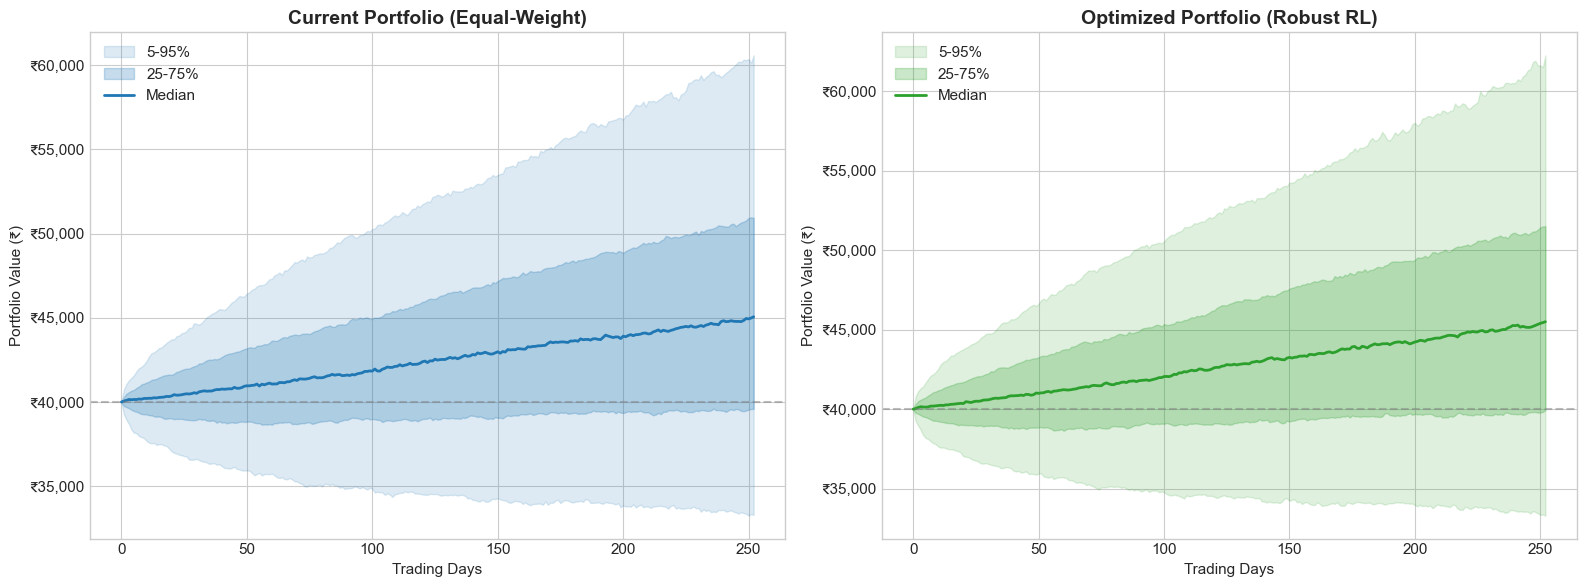

In [10]:
def plot_portfolio_fan_chart(result, ax, title, color='C0'):
    """Plot fan chart for a portfolio MC result."""
    paths = result.portfolio_paths
    n_steps = paths.shape[0]
    x = np.arange(n_steps)
    
    pct5 = np.percentile(paths, 5, axis=1)
    pct25 = np.percentile(paths, 25, axis=1)
    pct50 = np.percentile(paths, 50, axis=1)
    pct75 = np.percentile(paths, 75, axis=1)
    pct95 = np.percentile(paths, 95, axis=1)
    
    ax.fill_between(x, pct5, pct95, alpha=0.15, color=color, label='5-95%')
    ax.fill_between(x, pct25, pct75, alpha=0.25, color=color, label='25-75%')
    ax.plot(x, pct50, color=color, linewidth=2, label='Median')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Trading Days')
    ax.set_ylabel('Portfolio Value (₹)')
    ax.legend(loc='upper left')
    ax.axhline(result.initial_value, color='gray', linestyle='--', alpha=0.5)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x:,.0f}'))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_portfolio_fan_chart(comparison.current, axes[0], 'Current Portfolio (Equal-Weight)', color='C0')
plot_portfolio_fan_chart(comparison.optimized, axes[1], 'Optimized Portfolio (Robust RL)', color='C2')
plt.tight_layout()
plt.show()

## 10. Sample Paths Comparison

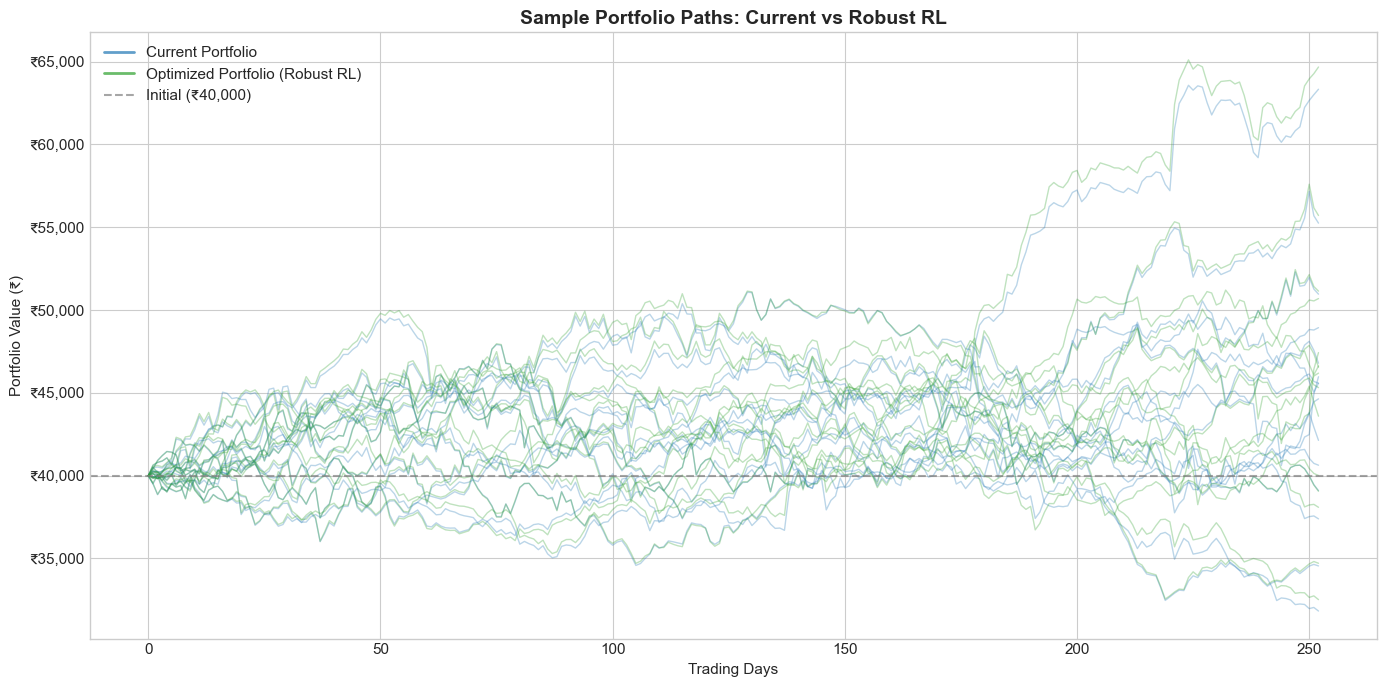

In [11]:
fig, ax = plt.subplots(figsize=(14, 7))

n_sample = min(15, comparison.current.portfolio_paths.shape[1])
x = np.arange(comparison.current.portfolio_paths.shape[0])

for i in range(n_sample):
    ax.plot(x, comparison.current.portfolio_paths[:, i], color='C0', alpha=0.3, linewidth=1.0)

for i in range(n_sample):
    ax.plot(x, comparison.optimized.portfolio_paths[:, i], color='C2', alpha=0.3, linewidth=1.0)

ax.plot([], [], color='C0', alpha=0.7, linewidth=2, label='Current Portfolio')
ax.plot([], [], color='C2', alpha=0.7, linewidth=2, label='Optimized Portfolio (Robust RL)')
ax.axhline(comparison.current.initial_value, color='gray', linestyle='--', 
           alpha=0.7, label=f'Initial (₹{comparison.current.initial_value:,.0f})')

ax.set_title('Sample Portfolio Paths: Current vs Robust RL', fontsize=14, fontweight='bold')
ax.set_xlabel('Trading Days')
ax.set_ylabel('Portfolio Value (₹)')
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x:,.0f}'))

plt.tight_layout()
plt.show()

## 11. Terminal Distribution Comparison

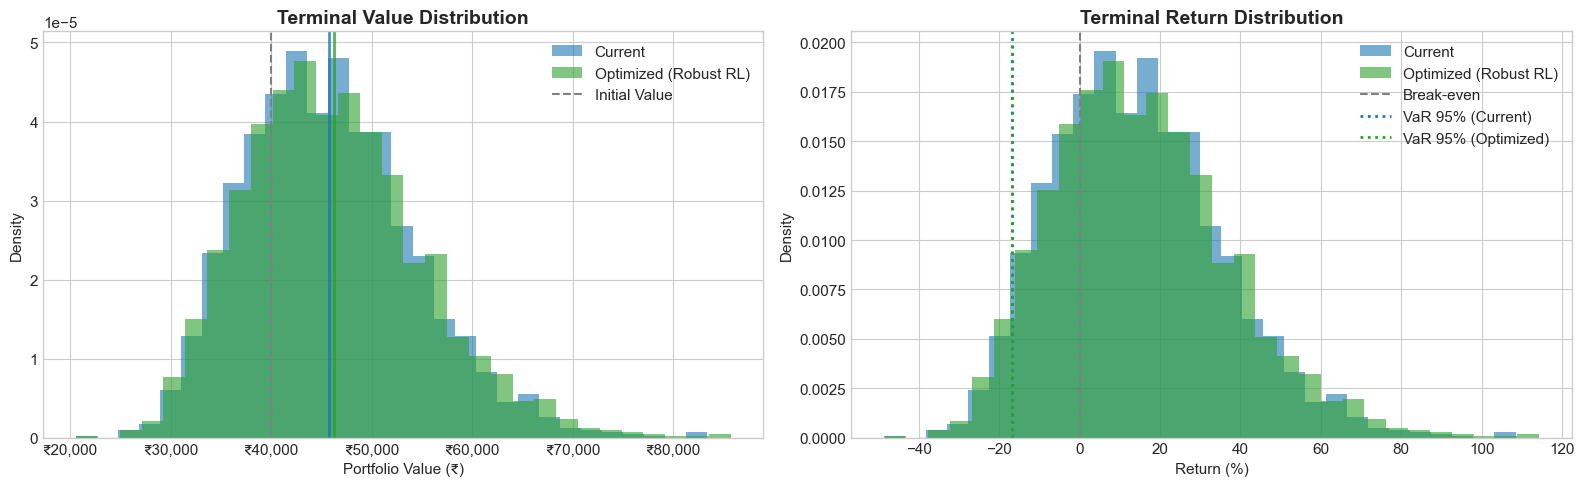

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Terminal Values Histogram
ax1 = axes[0]
bins = 30
ax1.hist(comparison.current.terminal_values, bins=bins, alpha=0.6, 
         color='C0', label='Current', density=True)
ax1.hist(comparison.optimized.terminal_values, bins=bins, alpha=0.6, 
         color='C2', label='Optimized (Robust RL)', density=True)
ax1.axvline(comparison.current.initial_value, color='gray', linestyle='--', 
            label='Initial Value')
ax1.axvline(comparison.current.mean_terminal_value, color='C0', linestyle='-', 
            linewidth=2, alpha=0.8)
ax1.axvline(comparison.optimized.mean_terminal_value, color='C2', linestyle='-', 
            linewidth=2, alpha=0.8)
ax1.set_title('Terminal Value Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Portfolio Value (₹)')
ax1.set_ylabel('Density')
ax1.legend()
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x:,.0f}'))

# Terminal Returns Histogram
ax2 = axes[1]
ax2.hist(comparison.current.terminal_returns * 100, bins=bins, alpha=0.6, 
         color='C0', label='Current', density=True)
ax2.hist(comparison.optimized.terminal_returns * 100, bins=bins, alpha=0.6, 
         color='C2', label='Optimized (Robust RL)', density=True)
ax2.axvline(0, color='gray', linestyle='--', label='Break-even')
ax2.axvline(comparison.current.var_95 * 100, color='C0', linestyle=':', 
            linewidth=2, label=f'VaR 95% (Current)')
ax2.axvline(comparison.optimized.var_95 * 100, color='C2', linestyle=':', 
            linewidth=2, label=f'VaR 95% (Optimized)')
ax2.set_title('Terminal Return Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Return (%)')
ax2.set_ylabel('Density')
ax2.legend()

plt.tight_layout()
plt.show()

## 12. Generate Recommendations

In [13]:
recs = generate_integrated_recommendations(
    price_df=price_df,
    current_weights=CURRENT_WEIGHTS,
    target_weights=TARGET_WEIGHTS,
    capital_config=capital_config,
    min_trade_value=100,
    min_trade_pct=0.005,
)

print(f"Generated {len(recs.recommendations)} recommendations")

Generated 5 recommendations


In [14]:
# Display Buy Recommendations
print("=" * 80)
print("BUY RECOMMENDATIONS")
print("=" * 80)

if recs.buy_recommendations:
    buy_data = []
    for rec in recs.buy_recommendations:
        buy_data.append({
            'Rank': rec.rank,
            'Ticker': rec.ticker,
            'Confidence': rec.confidence,
            'Delta Value': f'₹{rec.delta_value:,.2f}',
            'Weight Change': f'{rec.delta_weight:+.2%}',
            'Signal Score': f'{rec.signal_score:+.3f}',
            'Rationale': rec.rationale[:80] + '...' if len(rec.rationale) > 80 else rec.rationale,
        })
    buy_df = pd.DataFrame(buy_data)
    display(buy_df)
else:
    print("No buy recommendations.")

BUY RECOMMENDATIONS


,Rank,Ticker,Confidence,Delta Value,Weight Change,Signal Score,Rationale
0,1,AXISBANK.NS,MEDIUM,"₹1,963.22",+4.91%,-0.064,RL optimization suggests increasing AXISBANK.N...
1,2,ICICIBANK.NS,MEDIUM,"₹1,087.01",+2.72%,+0.204,RL optimization suggests increasing ICICIBANK....


In [15]:
# Display Sell Recommendations
print("=" * 80)
print("SELL RECOMMENDATIONS")
print("=" * 80)

if recs.sell_recommendations:
    sell_data = []
    for rec in recs.sell_recommendations:
        sell_data.append({
            'Rank': rec.rank,
            'Ticker': rec.ticker,
            'Confidence': rec.confidence,
            'Delta Value': f'₹{rec.delta_value:,.2f}',
            'Weight Change': f'{rec.delta_weight:+.2%}',
            'Signal Score': f'{rec.signal_score:+.3f}',
            'Rationale': rec.rationale[:80] + '...' if len(rec.rationale) > 80 else rec.rationale,
        })
    sell_df = pd.DataFrame(sell_data)
    display(sell_df)
else:
    print("No sell recommendations.")

SELL RECOMMENDATIONS


,Rank,Ticker,Confidence,Delta Value,Weight Change,Signal Score,Rationale
0,1,KOTAKBANK.NS,LOW,"₹-1,363.51",-3.41%,+0.140,RL optimization suggests reducing KOTAKBANK.NS...
1,2,HDFCBANK.NS,MEDIUM,₹-672.60,-1.68%,+0.034,RL optimization suggests reducing HDFCBANK.NS ...
2,3,RELIANCE.NS,LOW,₹-932.23,-2.33%,+0.148,RL optimization suggests reducing RELIANCE.NS ...


## 13. Allocation Comparison Visual

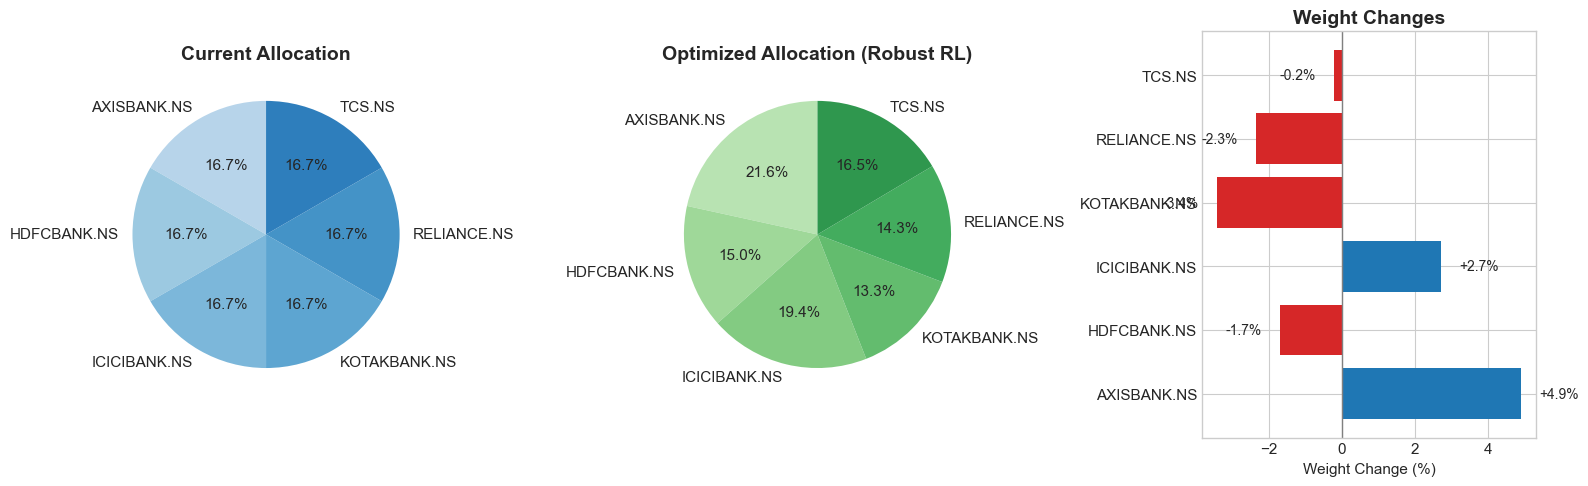

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

all_tickers = sorted(set(CURRENT_WEIGHTS.keys()) | set(TARGET_WEIGHTS.keys()))
current_vals = [CURRENT_WEIGHTS.get(t, 0) * 100 for t in all_tickers]
target_vals = [TARGET_WEIGHTS.get(t, 0) * 100 for t in all_tickers]
delta_vals = [target_vals[i] - current_vals[i] for i in range(len(all_tickers))]

colors = ['C0' if d >= 0 else 'C3' for d in delta_vals]

# Current Allocation Pie
ax1 = axes[0]
ax1.pie(current_vals, labels=all_tickers, autopct='%1.1f%%', startangle=90,
        colors=plt.cm.Blues(np.linspace(0.3, 0.7, len(all_tickers))))
ax1.set_title('Current Allocation', fontsize=14, fontweight='bold')

# Target Allocation Pie  
ax2 = axes[1]
ax2.pie(target_vals, labels=all_tickers, autopct='%1.1f%%', startangle=90,
        colors=plt.cm.Greens(np.linspace(0.3, 0.7, len(all_tickers))))
ax2.set_title('Optimized Allocation (Robust RL)', fontsize=14, fontweight='bold')

# Weight Changes Bar
ax3 = axes[2]
bars = ax3.barh(all_tickers, delta_vals, color=colors)
ax3.axvline(0, color='gray', linewidth=1)
ax3.set_xlabel('Weight Change (%)')
ax3.set_title('Weight Changes', fontsize=14, fontweight='bold')
for i, (bar, val) in enumerate(zip(bars, delta_vals)):
    ax3.text(val + 0.5 if val >= 0 else val - 0.5, i, f'{val:+.1f}%', 
             va='center', ha='left' if val >= 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

## 14. Full Reports

In [17]:
# Print full recommendations report
print(recs.generate_report())

INTEGRATED PORTFOLIO RECOMMENDATIONS
Combining RL Optimization with Asset Signal Analysis

Total Capital:          ₹50,000.00
Reserved Cash:          ₹10,000.00
Investable Capital:     ₹40,000.00

--------------------------------------------------------------------------------
BUY RECOMMENDATIONS (Ranked by Priority)
--------------------------------------------------------------------------------

  #1 AXISBANK.NS — MEDIUM Confidence
     Action: BUY ₹1,963.22 (+4.91% weight)
     Current: ₹6,666.67 (16.67%) → Target: ₹8,629.88 (21.57%)
     Signal Score: -0.064 (HOLD)
     Rationale: RL optimization suggests increasing AXISBANK.NS by +4.9%. (moderate positive risk adjusted return, moderate negative vol contribution).

  #2 ICICIBANK.NS — MEDIUM Confidence
     Action: BUY ₹1,087.01 (+2.72% weight)
     Current: ₹6,666.67 (16.67%) → Target: ₹7,753.67 (19.38%)
     Signal Score: +0.204 (INCREASE)
     Rationale: RL optimization suggests increasing ICICIBANK.NS by +2.7%. supported by fav

In [18]:
# Print full Monte Carlo comparison report
print(comparison.generate_report())

MONTE CARLO PORTFOLIO COMPARISON

Simulation Horizon: 252 steps
Number of Paths: 2000

--------------------------------------------------------------------------------
CURRENT PORTFOLIO
--------------------------------------------------------------------------------
  Initial Value:            ₹40,000.00
  Mean Terminal Value:      ₹45,729.35
  Std Terminal Value:        ₹8,487.00
  Mean Return:                14.32%
  Std Return:                 21.22%
  VaR (95%):                 -16.76%
  CVaR (95%):                -22.29%
  VaR (99%):                 -25.94%
  CVaR (99%):                -30.80%

  Weights:
    AXISBANK.NS: 16.67%
    HDFCBANK.NS: 16.67%
    ICICIBANK.NS: 16.67%
    KOTAKBANK.NS: 16.67%
    RELIANCE.NS: 16.67%
    TCS.NS: 16.67%

--------------------------------------------------------------------------------
OPTIMIZED PORTFOLIO (RL)
--------------------------------------------------------------------------------
  Initial Value:            ₹40,000.00
  Mean Termina

---

## Summary

This demo showed:

1. **Data Loading** - Fetching historical price data from Yahoo Finance
2. **Robust Inference** - Using ensemble + smoothing + cap/floor for stable weights
3. **Monte Carlo Simulation** - 2000 paths with block_bootstrap noise for reliable tail metrics
4. **Risk Metrics** - Comparing VaR, CVaR, Sharpe ratios
5. **Visualizations** - Fan charts, sample paths, terminal distributions
6. **Recommendations** - Ranked buy/sell suggestions with rationales

### Robust Inference Benefits

- **Start-step ensemble**: Reduces sensitivity to specific market conditions
- **Last-K smoothing**: Removes final-step noise, preserves policy signal
- **Cap + Floor**: Prevents extreme concentration, improves tail risk metrics
- **Softmax temperature**: Flattens overconfident allocations